<a href="https://colab.research.google.com/github/valyaler/innopolis/blob/master/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_COVID_19_Bangladesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение. Постановка целей и задач.

----
Цель: проведение исследования данных и построение прогноза развития пандемии COVID-19 в России.

Задачи:
- провести анализ данных о заболеваемости COVID-19 в России до 05.04.2021г.;
- предложить и настроить прогностическую модель о заболеваемости  COVID-19 в России;
- выполнить прогноз и сравнить результаты с новой статистикой (полученной после 5 апреля 2021 года) COVID-19 в России.
---

## Импорт библиотек, ознакомление с данными.

### Импорт Датафрейма, библиотек, написание функций.

In [1]:
# загружаем pmdarima
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 36.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# загружаем fbprophet
!pip install fbprophet

In [3]:
## Здесь импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [4]:
## Здесь импортируем данные
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [5]:
## Проверяем, что все выгрузилось корректно
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


### Знакомство с данными.

Этот блок посвящен первоначальному знакомству с данными

Наша задача - посмотреть на данные методами .info(), а также изучить их визуально.

Будет удобно рассматривать определенный блок - одну страну, один месяц одной страны.

Здесь же надо определиться с описанием данных - лучше всего для себя пояснить, с чем мы имеем дело. В данном случае столбцов слишком много, поэтому необходимо описать только самое важное - максимум 7-8 столбцов.
Как только у нас есть информация, что данные получены без ошибок, а также есть самое общее представление о содержимом, мы можем перейти к следующему пункту.

---
**Необходимо описать, что берем на вход (какие признаки из иходного датасета)**

Источник данных и его описание находится тут https://github.com/owid/covid-19-data/tree/master/public/data

Возможные метрики для прогнозирования:

1) total_cases - накопительный итогом кол-во новых случаев заболеваний

2) new_cases - новые случаи заболеваний за день

3) total_deaths - накопительный итогом кол-во смертей

4) new_deaths - новые случаи смертей за день

**Примечание**: При выполнении кейса разным студентам рекомендуется выбирать данные о случаях заболеваний (total_cases, new_cases) в разных странах.

---

In [6]:
# смотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149028 entries, 0 to 149027
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149028 non-null  object 
 1   continent                                   140034 non-null  object 
 2   location                                    149028 non-null  object 
 3   date                                        149028 non-null  object 
 4   total_cases                                 146418 non-null  float64
 5   new_cases                                   146412 non-null  float64
 6   new_cases_smoothed                          145267 non-null  float64
 7   total_deaths                                129414 non-null  float64
 8   new_deaths                                  129610 non-null  float64
 9   new_deaths_smoothed                         145267 non-null  float64
 

In [7]:
# смотрим список доступных стран и выбираем себе страну
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

---
Я выбираю Россию, то есть df.location == Russia

---

## Предобработка данных

### Фильтрация данных

---
Фильтрую данные по условию df.location == Russia, выбирая признаки: дата (день), страна и показатели (кол-во новых случаев заражения, смертей и соответствующие им итоговые значение в день)

---


In [8]:
df_new = df[df.location == 'Bangladesh'][['location', 'date', 'total_cases', 'new_cases', 'total_deaths','new_deaths']]

In [9]:
# проверяем
df_new.head(730) # 730 т.к. данные начали заполняться с 24.02.2020 берем 2 года в надежде что пандемия исчезнет

,location,date,total_cases,new_cases,total_deaths,new_deaths
11329,Bangladesh,2020-03-03,NaN,NaN,NaN,NaN
11330,Bangladesh,2020-03-04,NaN,NaN,NaN,NaN
11331,Bangladesh,2020-03-05,NaN,NaN,NaN,NaN
11332,Bangladesh,2020-03-06,NaN,NaN,NaN,NaN
11333,Bangladesh,2020-03-07,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
11983,Bangladesh,2021-12-17,1580750.0,191.0,28043.0,2.0
11984,Bangladesh,2021-12-18,1580872.0,122.0,28047.0,4.0
11985,Bangladesh,2021-12-19,1581083.0,211.0,28048.0,1.0
11986,Bangladesh,2021-12-20,1581343.0,260.0,28050.0,2.0


### Обработка пропусков

---
Так как пропуски (NaN) находятся из-за недоступности данных на определенный день, можно считать в такие дни, что показатель = 0.

---
Как работать с пропусками https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

---


In [10]:
df_new.isna() #для определения NaN значений

,location,date,total_cases,new_cases,total_deaths,new_deaths
11329,False,False,True,True,True,True
11330,False,False,True,True,True,True
11331,False,False,True,True,True,True
11332,False,False,True,True,True,True
11333,False,False,True,True,True,True
...,...,...,...,...,...,...
11983,False,False,False,False,False,False
11984,False,False,False,False,False,False
11985,False,False,False,False,False,False
11986,False,False,False,False,False,False


In [11]:
# проверим, в каждом ли признаке есть пропуски
df_check_nan = df_new.isna()

In [12]:
for i in df_check_nan.columns:
    print(f'Для признака {i} пропуски: ', df_check_nan[i].unique())

Для признака location пропуски:  [False]
Для признака date пропуски:  [False]
Для признака total_cases пропуски:  [ True False]
Для признака new_cases пропуски:  [ True False]
Для признака total_deaths пропуски:  [ True False]
Для признака new_deaths пропуски:  [ True False]


In [13]:
# можем заменить на 0, чтобы не прерывать временной ряд
df_new = df_new.fillna(0)

In [14]:
# проверим тип данных
df_new.dtypes

location         object
date             object
total_cases     float64
new_cases       float64
total_deaths    float64
new_deaths      float64
dtype: object

---
Необходимо для location и date поменять тип данных для корректного считывания и отображения

---

In [15]:
df_new['location'] = df_new['location'].astype('string')

df_new['date'] = pd.to_datetime(df_new['date'])

In [16]:
# проверим тип данных
df_new.dtypes

location                string
date            datetime64[ns]
total_cases            float64
new_cases              float64
total_deaths           float64
new_deaths             float64
dtype: object

### Вывод по этапу.

---
Данные в таком-то виде, сделали фиьлтрацию и замену типов, чтобы ..

---

## EDA (exploratory data analysis) или разведочный анализ данных.

---
Цель данного блока: познакомиться "поближе" с данными, которыми мы располагаем.

Задачи данного блока: 
- Сделать столбец с датами индексом;
- Вывести статистику по нужным столбцам;
- Построить графическое отображение столбцов;
- Выявить связи между признаками (почему заболеваемость может расти или падать и тп).

---

In [17]:
# Сделать столбец с датами индексом
df_new.index = df_new.date

In [18]:
# Смотрим размер выборки
len(df_new)

659

In [19]:
# Входная выборка для анализа
df_new.head(730)

,location,date,total_cases,new_cases,total_deaths,new_deaths
date,,,,,,
2020-03-03,Bangladesh,2020-03-03,0.0,0.0,0.0,0.0
2020-03-04,Bangladesh,2020-03-04,0.0,0.0,0.0,0.0
2020-03-05,Bangladesh,2020-03-05,0.0,0.0,0.0,0.0
2020-03-06,Bangladesh,2020-03-06,0.0,0.0,0.0,0.0
2020-03-07,Bangladesh,2020-03-07,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-12-17,Bangladesh,2021-12-17,1580750.0,191.0,28043.0,2.0
2021-12-18,Bangladesh,2021-12-18,1580872.0,122.0,28047.0,4.0
2021-12-19,Bangladesh,2021-12-19,1581083.0,211.0,28048.0,1.0


In [20]:
# Проведем расчет основных статистических метрик
df_new.describe()

,total_cases,new_cases,total_deaths,new_deaths
count,6.590000e+02,659.000000,659.000000,659.000000
mean,6.683723e+05,2400.051593,10895.758725,42.566009
std,5.289231e+05,2914.405099,9497.231804,54.028219
min,0.000000e+00,0.000000,0.000000,0.000000
25%,2.732030e+05,521.500000,3608.000000,11.000000
50%,5.329160e+05,1546.000000,8055.000000,27.000000
75%,1.004929e+06,2853.500000,16096.500000,43.000000
max,1.581634e+06,16230.000000,28051.000000,264.000000


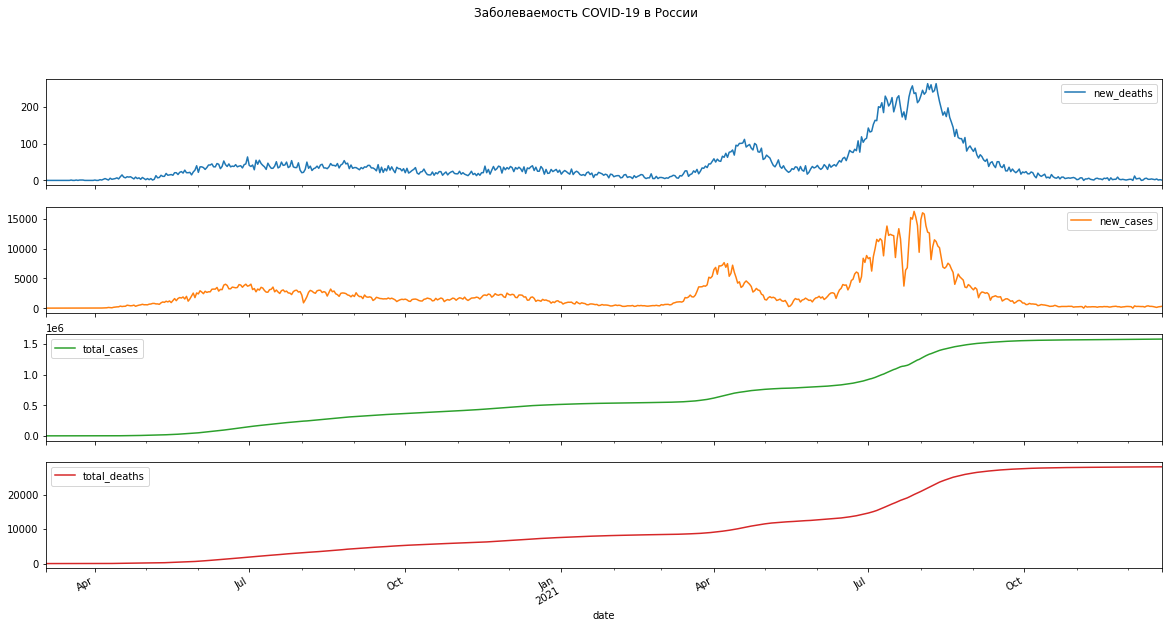

In [21]:
#построим общий график для метрик
df_new[['new_deaths', 'new_cases', 'total_cases', 'total_deaths']].plot(subplots=True, figsize=(20, 10), title = 'Заболеваемость COVID-19 в России');

---
Промежуточный вывод:


---

In [22]:
print('Максимальное значение новых заражений', max(df_new['new_cases']))
print('а максимальное значение новых смертельных случаев', max(df_new['new_deaths']))
print('что уже говорит о низкой летальности заболеваний.Обращаясь к данным медицинской')
print('статистики можно сделать вывод о том, чем менее летальный вирус, тем больше у него охват заражения.')

Максимальное значение новых заражений 16230.0
а максимальное значение новых смертельных случаев 264.0
что уже говорит о низкой летальности заболеваний.Обращаясь к данным медицинской
статистики можно сделать вывод о том, чем менее летальный вирус, тем больше у него охват заражения.


In [23]:
print('Отношение заболеваемости к смертности в 25%', (np.percentile(df_new['new_cases'],25)/np.percentile(df_new['new_deaths'],25)))
print('Отношение заболеваемости к смертности в 50%', (np.percentile(df_new['new_cases'],50)/np.percentile(df_new['new_deaths'],50)))
print('Отношение заболеваемости к смертности в 75%', (np.percentile(df_new['new_cases'],75)/np.percentile(df_new['new_deaths'],75)))
print('Отношение заболеваемости к смертности в Max', (max(df_new['new_cases'])/max(df_new['new_deaths'])))

Отношение заболеваемости к смертности в 25% 47.40909090909091
Отношение заболеваемости к смертности в 50% 57.25925925925926
Отношение заболеваемости к смертности в 75% 66.36046511627907
Отношение заболеваемости к смертности в Max 61.47727272727273


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22f41a0d90>,
      dtype=object)

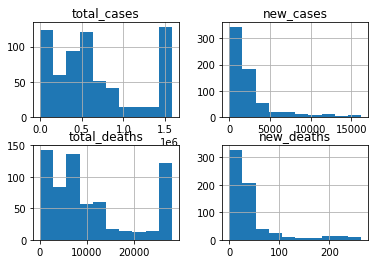

In [24]:
## построим гистограмму для определения распределения данных
df_new.hist()

---
Промежуточный вывод:

Анализ представленного ненормального распределения позволяет сделать вывод о пиковых нагрузках в период пандемии. Это отчетливо видно на общем графике: 3 основных пика, при этом последний сопровождается меньшим кол-вом смертей.

---

In [25]:
# построим матрицу корреляции признаков
df_new.corr()

,total_cases,new_cases,total_deaths,new_deaths
total_cases,1.000000,0.195558,0.997251,0.298006
new_cases,0.195558,1.000000,0.161718,0.933769
total_deaths,0.997251,0.161718,1.000000,0.264637
new_deaths,0.298006,0.933769,0.264637,1.000000


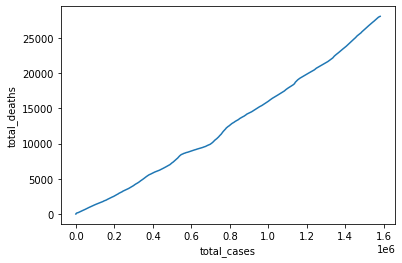

In [26]:
# построим график зависимости total_cases от total_deaths
sns.lineplot(data = df_new, x = 'total_cases', y = 'total_deaths')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



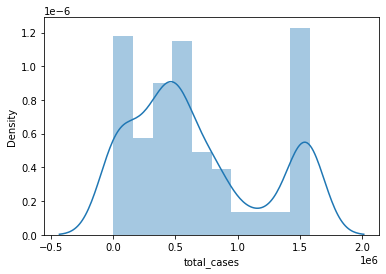

In [27]:
# график плотности распределения total_cases
sns.distplot(df_new.total_cases)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



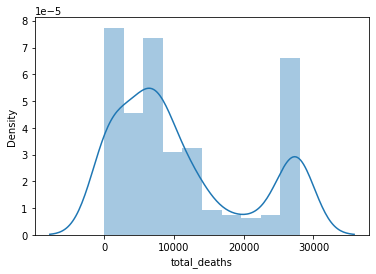

In [28]:
# график плотности распределения total_deaths
sns.distplot(df_new.total_deaths)

---
Промежуточный вывод:

Видим высокий уровень корреляции между кол-вом заболеваний и смертей, что свидетельствует о воздействии сходных факторов на уровень заболеваемости и общей смертности, где на графике видна практически близкая к линейной зависимости этих двух признаков.

Также на графиках KDE видим, что графики распределения подобны, благодаря этому наблюдению можно сформулировать гипотезу исследования:

***Если общее количество смертельных случаев выходит на плато, связано ли это со снижением новых случаев заражения?***

Для этого построим прогнозную модель расчёта новых случаев заражения.

---

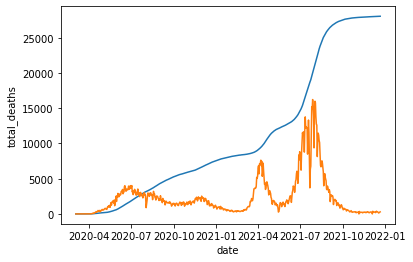

In [29]:
# при снижении новых случаев заболеваний кол-во смертей выходит на плато
sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
sns.lineplot(data = df_new, x = 'date', y = 'new_cases')

## Построение моделей, анализ результатов.

### Обучающая/контрольная выборки

In [30]:
# выделяем выборки, где тестовая размера 10 дней
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

In [31]:
#посмотрим на обучающую выборку
train.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths
date,,,,,,
2020-03-03,Bangladesh,2020-03-03,0.0,0.0,0.0,0.0
2020-03-04,Bangladesh,2020-03-04,0.0,0.0,0.0,0.0
2020-03-05,Bangladesh,2020-03-05,0.0,0.0,0.0,0.0
2020-03-06,Bangladesh,2020-03-06,0.0,0.0,0.0,0.0
2020-03-07,Bangladesh,2020-03-07,0.0,0.0,0.0,0.0


In [32]:
#посмотрим на тестовую выборку
test.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths
date,,,,,,
2021-12-12,Bangladesh,2021-12-12,1579325.0,329.0,28028.0,6.0
2021-12-13,Bangladesh,2021-12-13,1579710.0,385.0,28031.0,3.0
2021-12-14,Bangladesh,2021-12-14,1580005.0,295.0,28034.0,3.0
2021-12-15,Bangladesh,2021-12-15,1580302.0,297.0,28038.0,4.0
2021-12-16,Bangladesh,2021-12-16,1580559.0,257.0,28041.0,3.0


### ETS декомпозиция

In [33]:
r = seasonal_decompose(df_new['new_cases'])

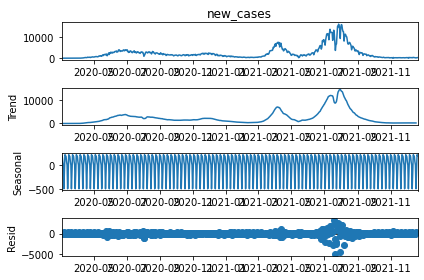

In [34]:
r.plot();

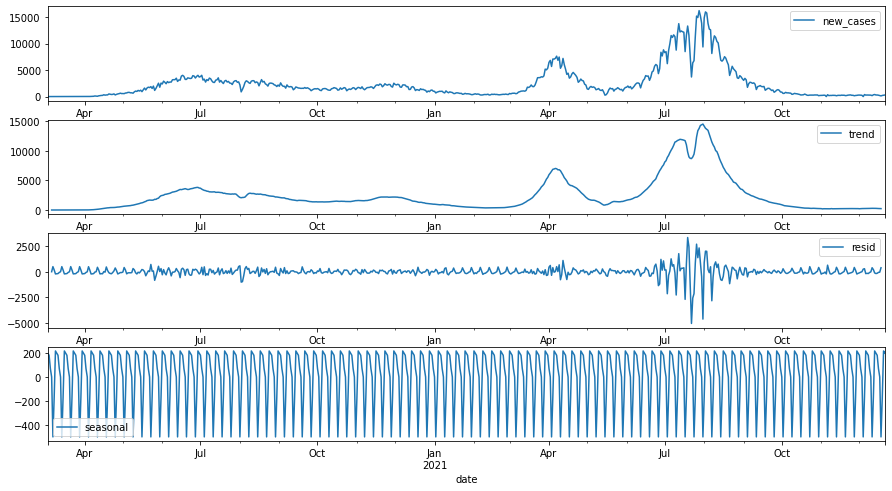

In [35]:
# seasonal_decompose в увеличенном виде
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
r.observed.plot(ax=ax1, legend=True)
r.trend.plot(ax=ax2, legend=True)
r.resid.plot(ax=ax3, legend=True)
r.seasonal.plot(ax=ax4, legend=True)

---
Промежуточный вывод:

На графике представлено распределение в пиковую нагрузку в июле-августе 2021. Наблюдаем недельную сезонность.

---

### Построение моделей

---
Задачи:
- описать модель
- подобрать оптимальные параметры
- создать модель
- обучить модель
- сделать прогноз на период тестовой выборки
- сравнить прогноз с тестовой выборкой (построить график)
- оценить качество прогноза
- сделать прогноз на 10-15 дней на будущее
- сделать выводы о работе данного метода прогнозирования

---

### 1й метод прогнозирования - SARIMAX

#### Описание модели SARIMAX: to do

In [37]:
# Запустим pmdarima.auto_arima чтобы получить набор параметров для нашей модели
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary() #включаем сезонность и указываем период сезонности = 7 дней

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  659
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -5092.362
Date:                             Wed, 22 Dec 2021   AIC                          10192.723
Time:                                     15:35:04   BIC                          10210.680
Sample:                                          0   HQIC                         10199.684
                                             - 659                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.5457      0.053     10.362      0.000       0.443       0.649
ar.S.L14       0.2368      0.033      7.287      0.000       0.173       0.301
ma.S.L7       -0.2428      0.058     -4.196      0.000      -0.356      -0.129
sigma2      3.172e+05   5865.502     54.078      0.000    3.06e+05    3.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):              8386.31
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               9.48   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---
Промежуточные выводы:

Получилась модель с параметрами SARIMAX(0, 1, 0)x(2, 0, [1], 7)

---

In [38]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['new_cases'],order=(0, 1, 0), seasonal_order=(2, 0, 1, 7))

#обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

#получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  649
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -5019.909
Date:                             Wed, 22 Dec 2021   AIC                          10047.817
Time:                                     15:36:10   BIC                          10065.713
Sample:                                 03-03-2020   HQIC                         10054.760
                                      - 12-11-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.5452      0.053     10.191      0.000       0.440       0.650
ar.S.L14       0.2371      0.033      7.184      0.000       0.172       0.302
ma.S.L7       -0.2423      0.059     -4.122      0.000      -0.357      -0.127
sigma2      3.222e+05   6054.502     53.216      0.000     3.1e+05    3.34e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):              7976.96
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               9.50   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(0, 1, 0)x(2, 0, [1], 7)	')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



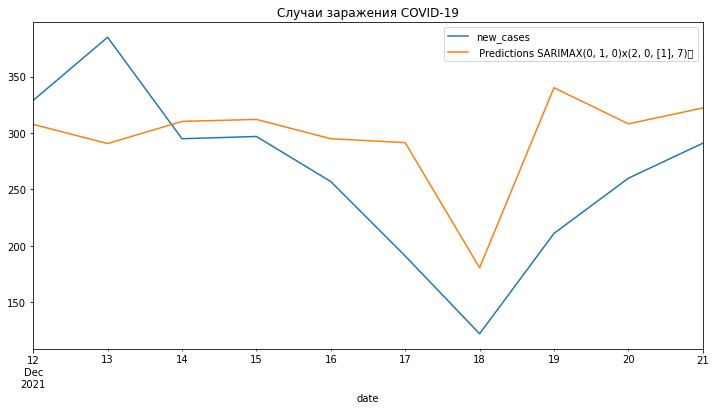

In [40]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [41]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error = rmse(test['new_cases'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(0, 1, 0)x(2, 0, [1], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(0, 1, 0)x(2, 0, [1], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(0, 1, 0)x(2, 0, [1], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(0, 1, 0)x(2, 0, [1], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(0, 1, 0)x(2, 0, [1], 7) MAE Error: 55.18643099
SARIMAX(0, 1, 0)x(2, 0, [1], 7) MSE Error: 4479.276309
SARIMAX(0, 1, 0)x(2, 0, [1], 7) RMSE Error:  66.9273958
SARIMAX(0, 1, 0)x(2, 0, [1], 7) MAPE Error: 24.72111852


In [42]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(0, 1, 0), seasonal_order=(2, 0, 1, 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  659
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 7)   Log Likelihood               -5092.362
Date:                             Wed, 22 Dec 2021   AIC                          10192.723
Time:                                     15:38:05   BIC                          10210.680
Sample:                                 03-03-2020   HQIC                         10199.684
                                      - 12-21-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.5457      0.053     10.362      0.000       0.443       0.649
ar.S.L14       0.2368      0.033      7.287      0.000       0.173       0.301
ma.S.L7       -0.2428      0.058     -4.196      0.000      -0.356      -0.129
sigma2      3.172e+05   5865.502     54.078      0.000    3.06e+05    3.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):              8386.31
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               9.48   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

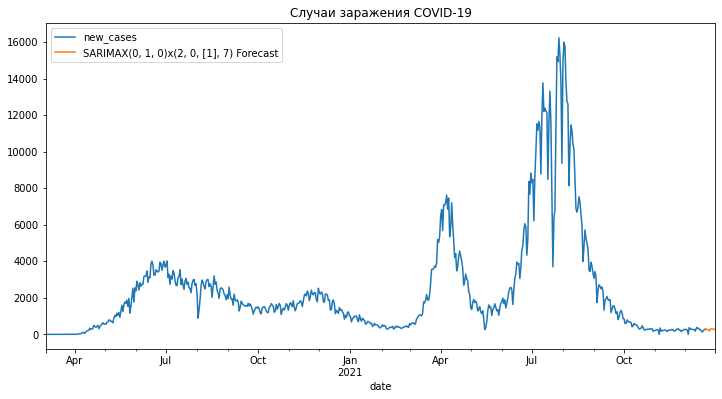

In [43]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(0, 1, 0)x(2, 0, [1], 7) Forecast')

#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

### Выводы работы метода SARIMAX

---
видим пик заболеваемости в июле-августе

---

### 2й метод прогнозирования - PROPHET

In [44]:
# подготовим данные для модели
train_prophet = train[['date','new_cases']]
test_prophet = test[['date','new_cases']]

# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [45]:
# подготовим данные по всему датасету для модели
df_new_prophet = df_new[['date','new_cases']]
df_new_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [46]:
# создаем модель с подобранными параметрами
# multiplicative - https://towardsdatascience.com/using-prophet-after-covid-read-this-first-fc27cd77f3d7

model_prophet = Prophet(seasonality_mode='multiplicative') #создаем объект модели профет, не устанавливая параметры (из дз помним, что модель сам-но подбирает параметры)

#обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---
Промежуточные выводы:

Алгоритм проигнорировал, выбирая параметры

1. `Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.`

    - годовую сезонность (*для годовой сезонности нам нужно иметь данные минимум за 2 года, чтобы суметь использовать ее в модели*)


2. `INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.`

    - дневную сезонность (*дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам*).

Зато он обнаружил недельную сезонность и использовал его при настройке модели.

---

In [47]:
# говорим профету сделать дата-фрейм на 10 дней вперед
future_prophet = model_prophet.make_future_dataframe(periods=10)

In [48]:
##предсказываем значения по модели
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-03-03,401.061713,-2161.534928,2899.122713,401.061713,401.061713,0.107370,0.107370,0.107370,0.107370,0.107370,0.107370,0.0,0.0,0.0,444.123589
1,2020-03-04,414.838171,-2066.654201,2955.582621,414.838171,414.838171,0.081757,0.081757,0.081757,0.081757,0.081757,0.081757,0.0,0.0,0.0,448.754130
2,2020-03-05,428.614628,-2216.463564,3126.169688,428.614628,428.614628,0.016532,0.016532,0.016532,0.016532,0.016532,0.016532,0.0,0.0,0.0,435.700519
3,2020-03-06,442.391086,-1929.537395,2999.123034,442.391086,442.391086,-0.010534,-0.010534,-0.010534,-0.010534,-0.010534,-0.010534,0.0,0.0,0.0,437.731061
4,2020-03-07,456.167543,-2438.860974,2880.388501,456.167543,456.167543,-0.263668,-0.263668,-0.263668,-0.263668,-0.263668,-0.263668,0.0,0.0,0.0,335.890868


In [49]:
#устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-03-03,2020-03-03,401.061713,-2161.534928,2899.122713,401.061713,401.061713,0.107370,0.107370,0.107370,0.107370,0.107370,0.107370,0.0,0.0,0.0,444.123589
2020-03-04,2020-03-04,414.838171,-2066.654201,2955.582621,414.838171,414.838171,0.081757,0.081757,0.081757,0.081757,0.081757,0.081757,0.0,0.0,0.0,448.754130
2020-03-05,2020-03-05,428.614628,-2216.463564,3126.169688,428.614628,428.614628,0.016532,0.016532,0.016532,0.016532,0.016532,0.016532,0.0,0.0,0.0,435.700519
2020-03-06,2020-03-06,442.391086,-1929.537395,2999.123034,442.391086,442.391086,-0.010534,-0.010534,-0.010534,-0.010534,-0.010534,-0.010534,0.0,0.0,0.0,437.731061
2020-03-07,2020-03-07,456.167543,-2438.860974,2880.388501,456.167543,456.167543,-0.263668,-0.263668,-0.263668,-0.263668,-0.263668,-0.263668,0.0,0.0,0.0,335.890868


---
Промежуточные выводы:

Основные поля в прогнозе следующие:
- `ds` — дата прогноза
- `yhat` — спрогнозированное значение

---



In [50]:
prediction_prophet[['ds', 'yhat']] # оставим только нужные

,ds,yhat
ds,,
2020-03-03,2020-03-03,444.123589
2020-03-04,2020-03-04,448.754130
2020-03-05,2020-03-05,435.700519
2020-03-06,2020-03-06,437.731061
2020-03-07,2020-03-07,335.890868
...,...,...
2021-12-17,2021-12-17,-1481.691661
2021-12-18,2021-12-18,-1144.118872
2021-12-19,2021-12-19,-1519.854807


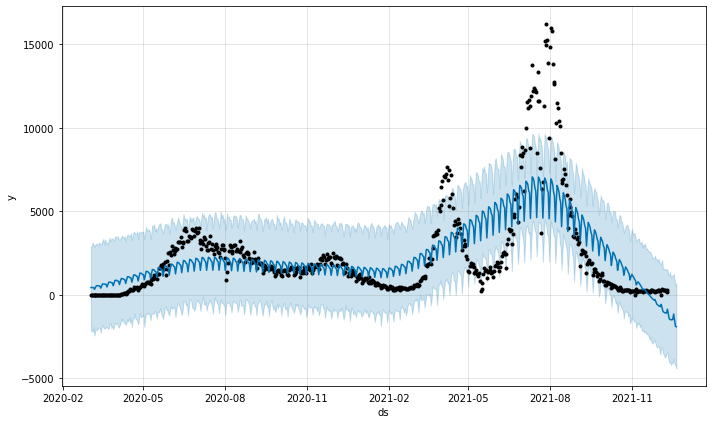

In [51]:
#сравниваем прогноз и тестовую выборку, где черные точки - выборка
model_prophet.plot(prediction_prophet);

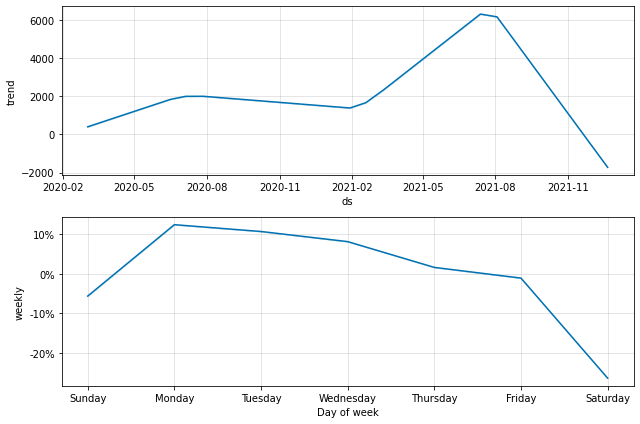

In [52]:
# разложим ряд на основные компоненты — тренд и сезонность
model_prophet.plot_components(prediction_prophet);

In [53]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 1757.787311
Prophet MSE Error: 3156920.231
Prophet RMSE Error:  1776.77242
Prophet MAPE Error: 710.3771756


In [54]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_new_prophet)

# говорим профету сделать дата-фрейм на 10 дней вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


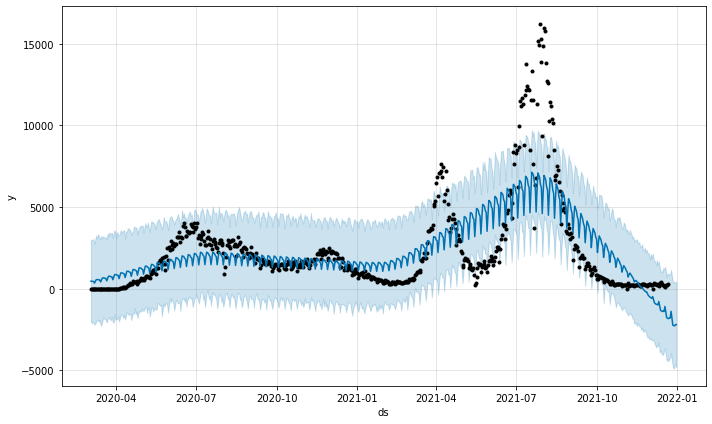

In [55]:
#сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet);

In [56]:
#устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [57]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-03-03,2020-03-03,417.335604,-1993.515322,2978.725364,417.335604,417.335604,0.104746,0.104746,0.104746,0.104746,0.104746,0.104746,0.0,0.0,0.0,461.050037
2020-03-04,2020-03-04,430.566708,-2110.727508,2992.989832,430.566708,430.566708,0.082410,0.082410,0.082410,0.082410,0.082410,0.082410,0.0,0.0,0.0,466.049497
2020-03-05,2020-03-05,443.797812,-2023.788327,3044.072525,443.797812,443.797812,0.017449,0.017449,0.017449,0.017449,0.017449,0.017449,0.0,0.0,0.0,451.541616
2020-03-06,2020-03-06,457.028916,-2072.638242,2970.851162,457.028916,457.028916,-0.009667,-0.009667,-0.009667,-0.009667,-0.009667,-0.009667,0.0,0.0,0.0,452.610809
2020-03-07,2020-03-07,470.260020,-2189.621323,2729.694649,470.260020,470.260020,-0.260502,-0.260502,-0.260502,-0.260502,-0.260502,-0.260502,0.0,0.0,0.0,347.756461


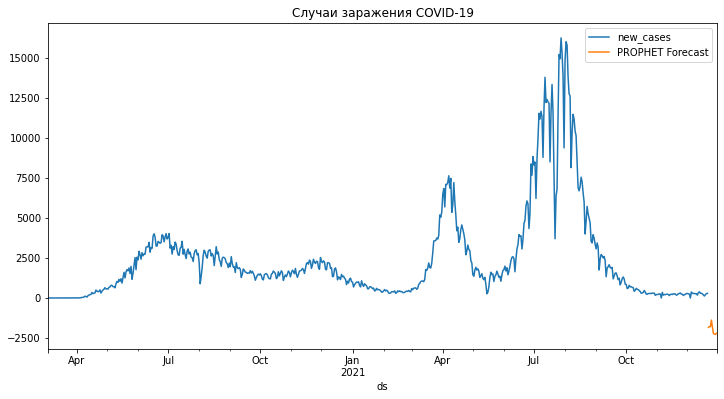

In [58]:
#строим график на будущее
ax = df_new_prophet['y'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["new_cases", "PROPHET Forecast"]);

### Выводы работы метода PROPHET

---
to do

---

### 3й метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)

#### Описание модели Exponential smoothing: to do

---
Экспоненциальное сглаживание — метод математического преобразования, используемый при прогнозировании временных рядов.

Метод также известен как метод простого экспоненциального сглаживания, или метод Брауна

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html


---

In [59]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [60]:
#посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 0.19999999999999984,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': 0.01818181818181821,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9714285714285713,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.0001,
 'use_boxcox': False}

In [61]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [62]:
test.index[0]

Timestamp('2021-12-12 00:00:00')

In [63]:
test.index[-1]

Timestamp('2021-12-21 00:00:00')

In [64]:
prediction_exps

array([179.64366345, 179.66327217, 179.68288088, 179.70248959,
       179.7220983 , 179.74170701, 179.76131573, 179.78092444,
       179.80053315, 179.82014186])

In [65]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-12-10 00:00:00", periods=10, freq="D")

prediction_exps.columns = ['prediction_exps']

In [66]:
#проверим
prediction_exps.head()

,prediction_exps
2021-12-10,179.643663
2021-12-11,179.663272
2021-12-12,179.682881
2021-12-13,179.702490
2021-12-14,179.722098


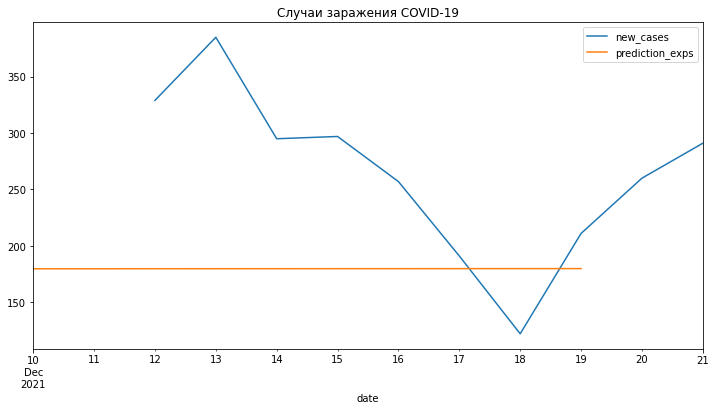

In [67]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [68]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['new_cases'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['new_cases'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(0, 1, 2)x(2, 0, [], 7) MAE Error: 95.62036049
SARIMAX(0, 1, 2)x(2, 0, [], 7) MSE Error: 12072.97698
SARIMAX(0, 1, 2)x(2, 0, [], 7) RMSE Error: 109.8770995
SARIMAX(0, 1, 2)x(2, 0, [], 7) MAPE Error: 34.41872841


In [69]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df_new['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность
fut_model_exps.fit()

#задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df_new)-1, end=len(df_new)+9)

#преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-12-19", periods=11, freq="D")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [70]:
#проверим
fut_fcast_exps.head()

,fut_fcast_exps
2021-12-19,258.557130
2021-12-20,290.103688
2021-12-21,290.134314
2021-12-22,290.164941
2021-12-23,290.195568


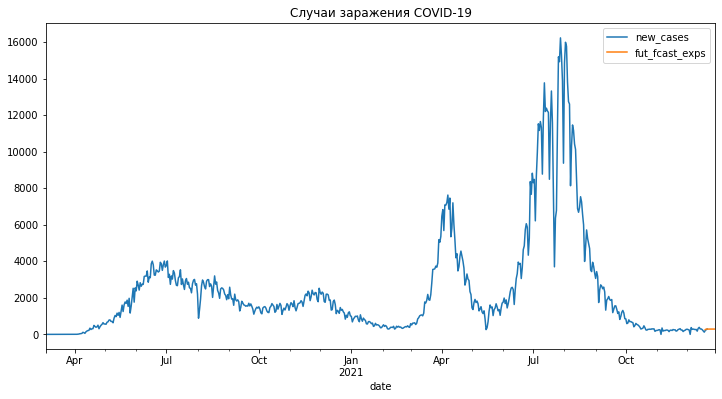

In [71]:
#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

### Выводы работы метода Exponential smoothing

---
to do

---

## Выводы

---
- Проведен анализ данных с использованием современных методов обработки статистической информации. 

- Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.

- Результаты анализа представленных данных помогли выявить зависимость новых случаев заражения и новых смертельных случаев от одних факторов.

- Прогнозная модель позволила зафиксировать выход на плато в категории новых случаев заражения, что соответствует тренду общего уровня смертности.

---

In [ ]:
## !!! Важно выделить, в чем различие методов, какие результаты получились и какая модель показала себя лучше всего!